In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as auc
from scipy.interpolate import make_interp_spline


In [2]:
# set to 0 if not running on GPU
USE_CUDA = 1

In [7]:
data = pd.read_csv('train/train/subj1_series1_data.csv')
ev = pd.read_csv('train/train/subj1_series1_events.csv')

In [8]:
data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,550,324,346,76,547,343,446,171,67,581


In [9]:
ev.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,0,0,0,0,0,0
1,subj1_series1_1,0,0,0,0,0,0
2,subj1_series1_2,0,0,0,0,0,0
3,subj1_series1_3,0,0,0,0,0,0
4,subj1_series1_4,0,0,0,0,0,0


In [10]:
class eegdata(Dataset):
    
    def __init__(self, path, validation=False, subjects=range(1,13)):
        super().__init__()
        data, self.target = self.readfiles(path, validation, subjects)
        self.mean= data.mean(axis=0)
        self.std = data.std(axis=0)
        self.data = self.norm(data)
    
    def norm(self, x):
        return ((x - self.mean)/self.std)
    
    def to_np(self, values):
        
        #get total lines of data count
        count = 0
        for i in range(len(values)):
            count += len(values[i])
        
        #create np array size of all data
        ret = np.zeros((count, len(values[0][0])))
        
        #copy data into np array 
        ix = 0
        for i in range(len(values)):
            ret[ix:ix+len(values[i]), :] = values[i]
            ix += len(values[i])
        return ret
        
    
    def readfiles(self, path, validation, subjects):
        
        allx = []
        ally = []
        
        series = [1,2,4,5,6,7,8] if validation == False else [3]
        
        for i in subjects:
            print('log: reading subject {}...'.format(i))
            xs = None
            ys = None
            for j in series:

                data = 'subj{}_series{}_data.csv'.format(i,j)
                events = 'subj{}_series{}_events.csv'.format(i,j)

                x = pd.read_csv(path + data).values[:, 1:]
                xs = x if xs is None else np.vstack((xs, x))

                y = pd.read_csv(path + events).values[:, 1:]
                ys = y if ys is None else np.vstack((ys, y))

            allx.append(xs)
            ally.append(ys)

        xs = self.to_np(allx)
        ys = self.to_np(ally)

        return xs, ys
                    
    
    def __getitem__(self, index):
        return self.data[index], self.target[index]
        
    def __len__(self):
        return len(self.data)
                    

In [30]:
PATH = 'C:/Users/User/Documents/grasp-and-lift-eeg-detection/train/'
subjects=range(1,13)
traindata = eegdata(f'{PATH}train/', subjects=subjects)
valdata = eegdata(f'{PATH}train/', subjects=subjects, validation=True)

log: reading subject 1...
log: reading subject 2...
log: reading subject 3...
log: reading subject 4...
log: reading subject 5...
log: reading subject 6...
log: reading subject 7...
log: reading subject 8...
log: reading subject 9...
log: reading subject 10...
log: reading subject 11...
log: reading subject 12...
log: reading subject 1...
log: reading subject 2...
log: reading subject 3...
log: reading subject 4...
log: reading subject 5...
log: reading subject 6...
log: reading subject 7...
log: reading subject 8...
log: reading subject 9...
log: reading subject 10...
log: reading subject 11...
log: reading subject 12...


In [31]:
def get_individuals(individuals=range(1,13)):
          
    subjects = []
    vals = []

    for i in individuals:
    
        s = [i]
        subject = eegdata(f'{PATH}train/', subjects=s)
        v = eegdata(f'{PATH}train/', validation=True, subjects=s)
        subjects.append(subject)
        vals.append(v)
        
    return subjects, vals

In [32]:
subjects, vals = get_individuals()

log: reading subject 1...
log: reading subject 1...
log: reading subject 2...
log: reading subject 2...
log: reading subject 3...
log: reading subject 3...
log: reading subject 4...
log: reading subject 4...
log: reading subject 5...
log: reading subject 5...
log: reading subject 6...
log: reading subject 6...
log: reading subject 7...
log: reading subject 7...
log: reading subject 8...
log: reading subject 8...
log: reading subject 9...
log: reading subject 9...
log: reading subject 10...
log: reading subject 10...
log: reading subject 11...
log: reading subject 11...
log: reading subject 12...
log: reading subject 12...


In [33]:
def get_spike(subject, event, average=True, sampling_rate=500):
    """
    Extract the average EEG signal around a specific event.

    Parameters:
    - subject (int): The subject index.
    - event (int): The event index.
    - average (bool): Whether to average across all channels or not.
    - sampling_rate (int): The sampling rate of the EEG data in Hz.

    Returns:
    - spike (np.ndarray): The averaged EEG signal.
    """
    # Calculate the number of samples corresponding to the time window
    pre_event_samples = int(200 / (1000 / sampling_rate))
    post_event_samples = int(300 / (1000 / sampling_rate))
    
    spike = np.zeros([pre_event_samples + post_event_samples + 1, 32])
    s = subject

    # Find the indexes where the event occurs
    indexes = np.where(subjects[s].target[:, event] == 1)[0]
    i = 0
    div = 0
    
    while i < len(indexes):
        # Ensure indexes are within the valid range to avoid out-of-bounds errors
        if indexes[i] - pre_event_samples >= 0 and indexes[i] + post_event_samples < len(subjects[s].data):
            ix = subjects[s].data[indexes[i] - pre_event_samples:indexes[i] + post_event_samples + 1]
            spike += ix
            div += 1
        i += 150

    if div > 0:
        spike /= div
    
    if average:
        # Average the spike across all channels
        spike = spike.mean(axis=1)
        
    return spike


In [34]:
def plot_spike(subject, event, average=True, sampling_rate=500):
    """
    Plot the EEG signal changes around a specific event.

    Parameters:
    - subject (int): The subject index.
    - event (int): The event index.
    - average (bool): Whether to plot the average across all channels.
    - sampling_rate (int): The sampling rate of the EEG data in Hz.
    """
    spike = get_spike(subject, event, average, sampling_rate)
    
    # Create a time vector in milliseconds
    time_points = np.linspace(-200, 300, len(spike))
    
    plt.figure(figsize=(15, 8))
    if average:
        plt.plot(time_points, spike, label=f'Event {event}', color='b')
        plt.xlabel('Time (ms)')
        plt.ylabel('Average Voltage (uV)')
    else:
        for channel in range(spike.shape[1]):
            plt.plot(time_points, spike[:, channel], label=f'Channel {channel + 1}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage (uV)')
    
    plt.title(f'EEG Signal Changes for Subject {subject + 1}, Event {event}')
    plt.axvline(x=0, color='r', linestyle='--', label='Event Onset')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


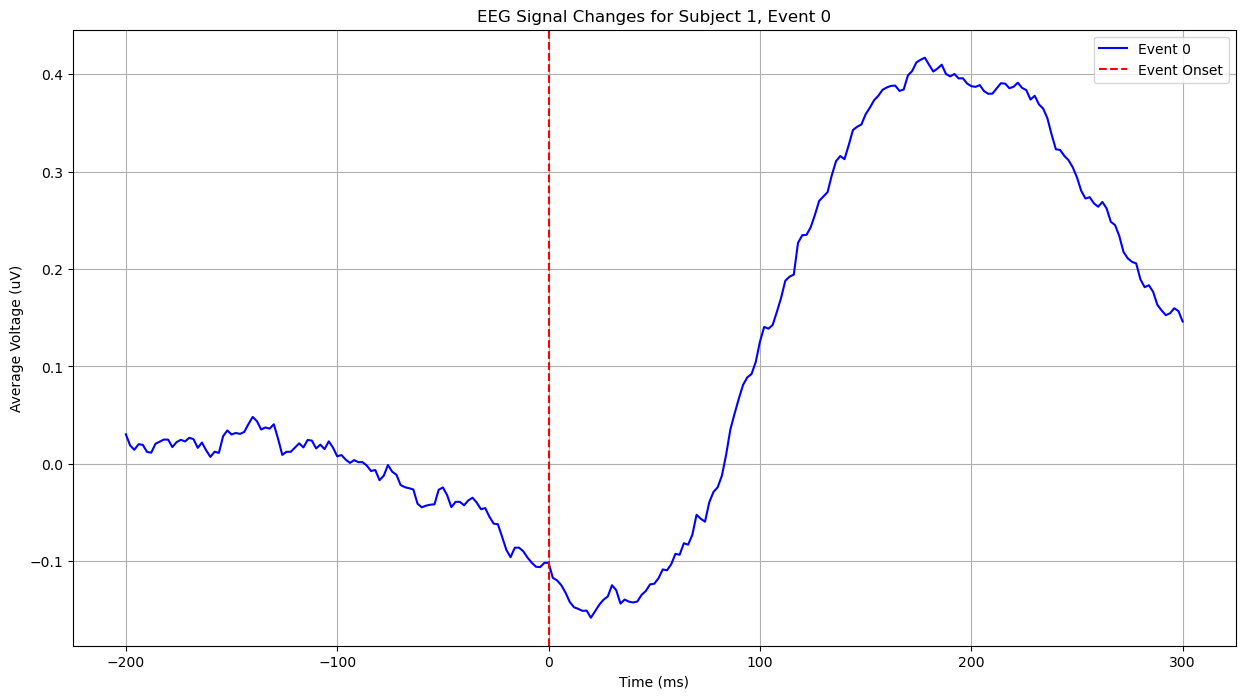

In [35]:
# Example: Visualize the EEG signals for subject 0 (1st subject) and event 0 (HandStart)
plot_spike(subject=0, event=0, average=True)

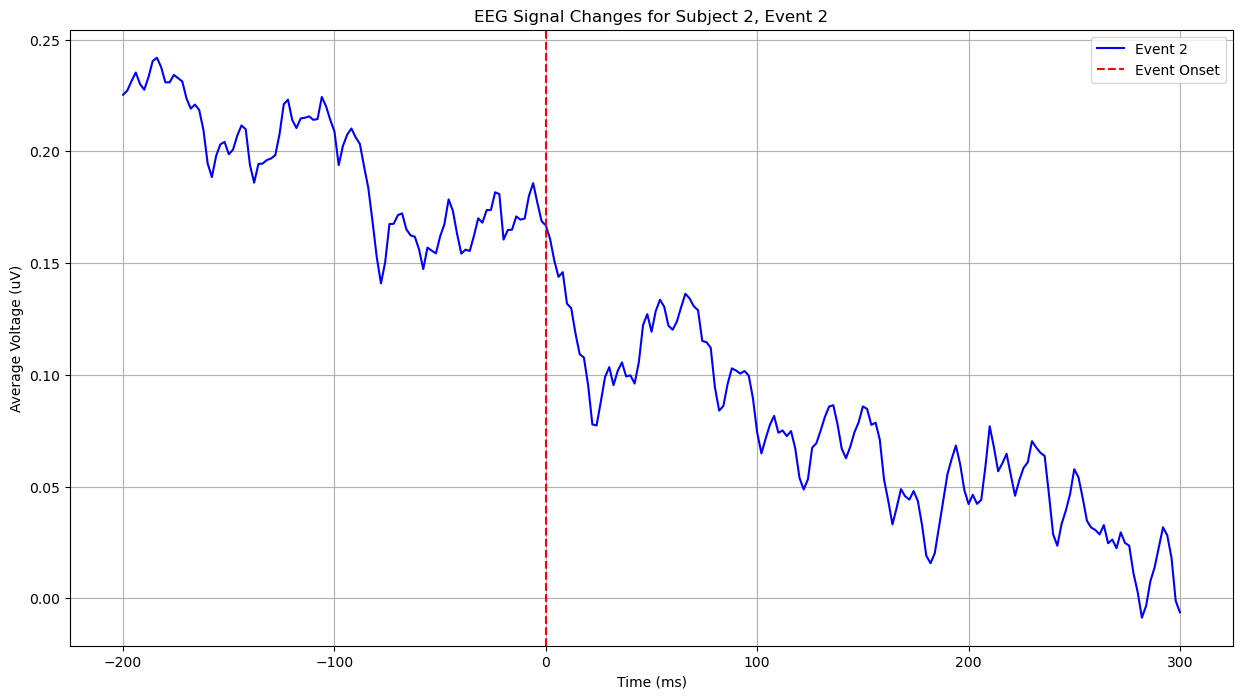

In [36]:
plot_spike(subject=1, event=2, average=True, sampling_rate=500)  # Visualize BothStartLoadPhase for the second subject




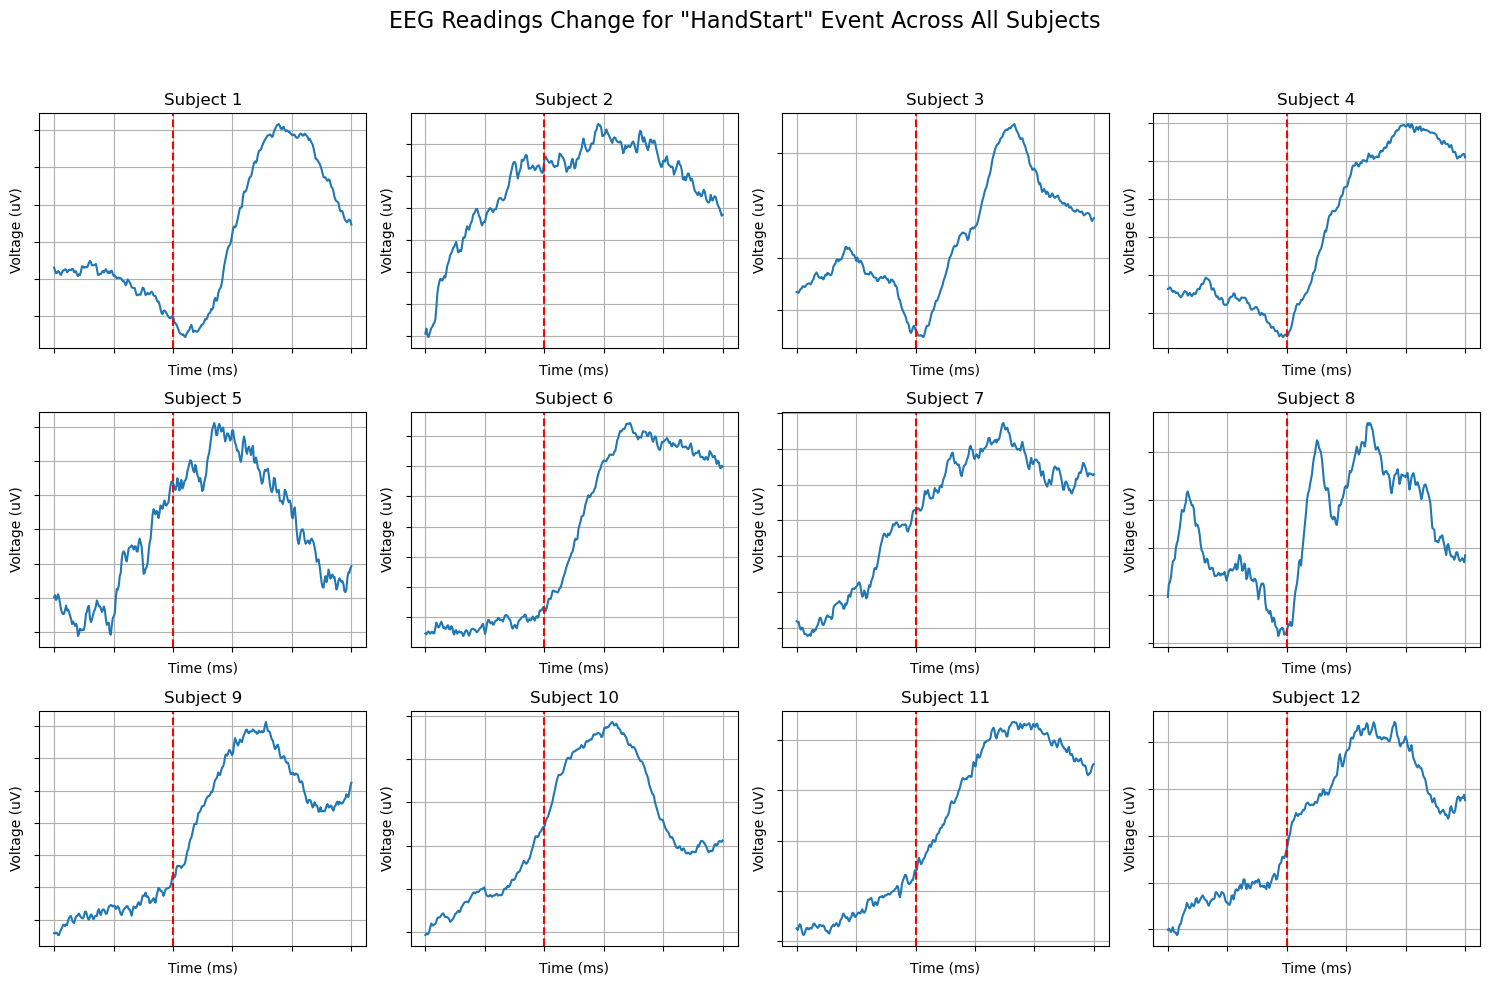

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Function to generate the spike data for all subjects for a specific event
def plot_all_subjects(event=0, subjects=12, sampling_rate=500):
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    fig.suptitle('EEG Readings Change for "HandStart" Event Across All Subjects', fontsize=16)

    for s in range(subjects):
        spike = get_spike(s, event)
        time_points = np.linspace(-200, 300, len(spike))
        
        # Smoothing using B-spline
        xnew = np.linspace(time_points.min(), time_points.max(), 300)
        spline = make_interp_spline(time_points, spike, k=3)
        smooth_spike = spline(xnew)

        ax = axes[s // 4, s % 4]
        ax.plot(xnew, smooth_spike)
        ax.axvline(x=0, color='r', linestyle='--')  # Event onset line

        ax.set_title(f'Subject {s+1}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Voltage (uV)')
        ax.grid(True)
        
        # Hide tick labels for cleaner look
        ax.set_xticklabels([] if s % 4 != 0 else [])
        ax.set_yticklabels([] if s < 8 else [])
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for the main title
    plt.show()

# Function call to plot EEG readings for the 'HandStart' action across all 12 subjects
plot_all_subjects(event=0, subjects=12)
